In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [ ]:
class RobustPortfolioOptimizer:
    def __init__(self, returns_data):
        """
        Initialize the optimizer with historical returns data
        Parameters:
        returns_data (pd.DataFrame): Historical returns data
        """
        self.returns = returns_data
        self.n_assets = returns_data.shape[1]

    def calculate_historical_var(self, weights, confidence_level=0.95):
        """
        Calculate Historical VaR
        """
        portfolio_returns = self.returns @ weights
        return -np.percentile(portfolio_returns, (1 - confidence_level) * 100)

    def calculate_historical_cvar(self, weights, confidence_level=0.95):
        """
        Calculate Historical CVaR
        """
        portfolio_returns = self.returns @ weights
        var = -np.percentile(portfolio_returns, (1 - confidence_level) * 100)
        return -np.mean(portfolio_returns[portfolio_returns <= -var])

    def calculate_modified_sharpe(self, weights):
        """
        Calculate Modified Sharpe Ratio using CVaR instead of standard deviation
        """
        portfolio_returns = self.returns @ weights
        mean_return = np.mean(portfolio_returns)
        cvar = self.calculate_historical_cvar(weights)
        return mean_return / cvar if cvar != 0 else -np.inf

    def optimize_portfolio(self, objective='modified_sharpe', constraints=None, bounds=None, additional_constraints=None):
        """
        Optimize portfolio based on selected objective
        Parameters:
        objective (str): 'modified_sharpe', 'min_cvar', or 'mean_cvar'
        constraints (dict): Additional constraints for optimization
        """
        initial_weights = np.array([1/self.n_assets] * self.n_assets)

        if bounds is None:
            bounds = [(0, 1) for _ in range(self.n_assets)]

        # Basic constraints
        constraints_list = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # weights sum to 1
        ]

        if constraints:
            # Add user-defined constraints
            if 'min_weight' in constraints:
                constraints_list.append(
                    {'type': 'ineq', 'fun': lambda x: x - constraints['min_weight']}
                )
            if 'max_weight' in constraints:
                constraints_list.append(
                    {'type': 'ineq', 'fun': lambda x: constraints['max_weight'] - x}
                )

        if additional_constraints:
            constraints_list.extend(additional_constraints)

        if objective == 'modified_sharpe':
            objective_function = lambda x: -self.calculate_modified_sharpe(x)
        elif objective == 'min_cvar':
            objective_function = lambda x: self.calculate_historical_cvar(x)
        elif objective == 'mean_cvar':
            def objective_function(x):
                returns = np.mean(self.returns @ x)
                cvar = self.calculate_historical_cvar(x)
                return -(returns - 0.5 * cvar)  # Parameter 0.5 can be adjusted

        result = minimize(objective_function,
                        initial_weights,
                        method='SLSQP',
                        bounds=bounds,
                        constraints=constraints_list)

        # Check if optimization was successful
        if not result.success:
            print("Optimization failed:", result.message)

        # Calculate risk (CVaR) for the optimized weights
        optimized_weights = result.x
        optimized_risk = self.calculate_historical_cvar(optimized_weights)
        print(f"Optimized Weights: {optimized_weights}, Optimized Risk: {optimized_risk}")

        return result.x

    def calculate_portfolio_metrics(self, weights):
        """
        Calculate comprehensive portfolio metrics
        """
        portfolio_returns = self.returns @ weights
        metrics = {
            'mean_return': np.mean(portfolio_returns),
            'volatility': np.std(portfolio_returns),
            'historical_var_95': self.calculate_historical_var(weights),
            'historical_cvar_95': self.calculate_historical_cvar(weights),
            'modified_sharpe': self.calculate_modified_sharpe(weights),
            'skewness': stats.skew(portfolio_returns),
            'kurtosis': stats.kurtosis(portfolio_returns)
        }
        return metrics

In [78]:
class PortfolioAnalyzer:
    def __init__(self, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date

    def get_data(self, tickers):
        data = pd.DataFrame()
        valid_tickers = []

        print("Mengunduh data...")
        for ticker in tickers:
            try:
                stock = yf.download(ticker, start=self.start_date, end=self.end_date)
                if not stock.empty and len(stock) > 0:
                    returns = stock['Close'].pct_change()
                    if len(returns.dropna()) > 0:
                        data[ticker] = returns
                        valid_tickers.append(ticker)
            except Exception as e:
                print(f"Error mengunduh {ticker}: {e}")

        data = data.dropna()
        return data, valid_tickers

    def analyze_individual_stocks(self, returns_data):
        metrics = pd.DataFrame()

        for col in returns_data.columns:
            returns = returns_data[col].dropna()

            if returns.empty:
                continue

            metrics.at[col, 'Mean Return'] = returns.mean()
            metrics.at[col, 'Volatility'] = returns.std()
            metrics.at[col, 'Sharpe Ratio'] = returns.mean() / returns.std()
            metrics.at[col, 'Skewness'] = stats.skew(returns)
            metrics.at[col, 'Kurtosis'] = stats.kurtosis(returns)

        return metrics.sort_values('Sharpe Ratio', ascending=False)

    def optimize_portfolio(self, returns_data, n_portfolios=1000):
        optimizer = RobustPortfolioOptimizer(returns_data)

        results = {
            'modified_sharpe': optimizer.optimize_portfolio(objective='modified_sharpe'),
            'min_cvar': optimizer.optimize_portfolio(objective='min_cvar'),
            'mean_cvar': optimizer.optimize_portfolio(objective='mean_cvar')
        }

        portfolio_metrics = {}
        for objective, weights in results.items():
            metrics = optimizer.calculate_portfolio_metrics(weights)
            portfolio_metrics[objective] = {
                'weights': pd.Series(weights, index=returns_data.columns),
                'metrics': metrics
            }
        return portfolio_metrics

    def generate_efficient_frontier(self, returns_data, n_points=100):
        optimizer = RobustPortfolioOptimizer(returns_data)
        frontier_points = []

        min_risk_weights = optimizer.optimize_portfolio(objective='min_cvar')
        max_return_weights = optimizer.optimize_portfolio(objective='modified_sharpe')

        min_return = optimizer.calculate_portfolio_metrics(min_risk_weights)['mean_return']
        max_return = optimizer.calculate_portfolio_metrics(max_return_weights)['mean_return']
        print("Min Return:", min_return)
        print("Max Return:", max_return)

        target_returns = np.linspace(min_return, max_return)

        for target in target_returns:
            target_return_constraint = [
                {'type': 'eq', 'fun': lambda x: np.mean(returns_data @ x) - target}
            ]

            bounds = [(0, 1) for _ in range(returns_data.shape[1])]

            weights = optimizer.optimize_portfolio(
                objective='min_cvar', 
                bounds=bounds, 
                additional_constraints=target_return_constraint)

            metrics = optimizer.calculate_portfolio_metrics(weights)

            frontier_points.append({
                'return': metrics['mean_return'],
                'risk': metrics['historical_cvar_95'],
                'weights': weights
            })

        print("Total Points on Frontier:", len(frontier_points))

        return pd.DataFrame(frontier_points)

    def calculate_benchmark_performance(self, returns_data):
        equal_weights = np.ones(len(returns_data.columns)) / len(returns_data.columns)
        mean_return = np.dot(returns_data.mean(), equal_weights)
        portfolio_std = np.sqrt(np.dot(equal_weights.T, np.dot(returns_data.cov(), equal_weights)))
        sharpe_ratio = mean_return / portfolio_std

        return {
            'Mean Return': mean_return,
            'Volatility': portfolio_std,
            'Sharpe Ratio': sharpe_ratio
        }

    def monte_carlo_simulation(self, returns_data, n_simulations=1000):
        """
        Melakukan simulasi Monte Carlo untuk membandingkan strategi optimasi portofolio.
        
        Args:
            returns_data (DataFrame): Data return historis
            n_simulations (int): Jumlah simulasi yang akan dilakukan
            
        Returns:
            DataFrame: Hasil simulasi dalam format yang terstruktur
        """
        # Debug info
        print(f"Mulai simulasi Monte Carlo dengan {n_simulations} iterasi...")
        print(f"Data returns shape: {returns_data.shape}")
        
        # Siapkan dictionary untuk menyimpan hasil
        simulation_results = []
        
        for sim_id in range(n_simulations):
            try:
                # Progress update
                if sim_id % 10 == 0:
                    print(f"Menjalankan simulasi {sim_id + 1}/{n_simulations}...")
                
                # Sampel ulang data dengan bootstrap
                simulated_returns = returns_data.sample(n=len(returns_data), replace=True)
                
                # Optimasi portofolio dengan berbagai strategi
                portfolio_results = self.optimize_portfolio(simulated_returns)
                
                # Simpan hasil untuk setiap strategi
                for strategy, portfolio_data in portfolio_results.items():
                    metrics = portfolio_data['metrics']
                    
                    result = {
                        'simulation_id': sim_id,
                        'strategy': strategy,
                        'mean_return': metrics.get('mean_return', 0),
                        'volatility': metrics.get('volatility', 0),
                        'sharpe_ratio': metrics.get('mean_return', 0) / metrics.get('volatility', 0)
                    }
                    
                    # Tambahkan metrik tambahan jika tersedia
                    if 'historical_var_95' in metrics:
                        result['historical_var_95'] = metrics['historical_var_95']
                    if 'historical_cvar_95' in metrics:
                        result['historical_cvar_95'] = metrics['historical_cvar_95']
                    if 'modified_sharpe' in metrics:
                        result['modified_sharpe'] = metrics['modified_sharpe']
                    
                    simulation_results.append(result)
            except Exception as e:
                print(f"Error pada simulasi {sim_id}: {e}")
                continue
        
        # Konversi ke DataFrame
        if not simulation_results:
            print("PERINGATAN: Tidak ada hasil simulasi yang berhasil!")
            return pd.DataFrame()
            
        results_df = pd.DataFrame(simulation_results)
        
        # Debug info
        print(f"Simulasi Monte Carlo selesai.")
        print(f"Ukuran hasil DataFrame: {results_df.shape}")
        print(f"Kolom hasil: {results_df.columns.tolist()}")
        print(f"Strategi yang dianalisis: {results_df['strategy'].unique().tolist()}")
        
        return results_df

    def plot_monte_carlo_results(self, monte_carlo_results):
        """
        Membuat visualisasi dari hasil simulasi Monte Carlo.
        
        Args:
            monte_carlo_results (DataFrame): Hasil dari simulasi Monte Carlo
        """
        # Validasi input
        if not isinstance(monte_carlo_results, pd.DataFrame) or monte_carlo_results.empty:
            print("PERINGATAN: Tidak ada data yang valid untuk divisualisasikan!")
            return
        
        if 'strategy' not in monte_carlo_results.columns:
            print("PERINGATAN: Kolom 'strategy' tidak ditemukan dalam data!")
            print(f"Kolom yang tersedia: {monte_carlo_results.columns.tolist()}")
            return
        
        try:
            # Kita akan membuat beberapa subplot
            fig, axes = plt.subplots(3, 1, figsize=(12, 18))
            
            # 1. Distribusi Return
            sns.boxplot(x='strategy', y='mean_return', data=monte_carlo_results, ax=axes[0])
            axes[0].set_title('Distribusi Return dari Simulasi Monte Carlo')
            axes[0].set_xlabel('Strategi Optimasi')
            axes[0].set_ylabel('Expected Return')
            
            # 2. Distribusi Risiko (CVaR jika ada, atau Volatility)
            if 'historical_cvar_95' in monte_carlo_results.columns:
                sns.boxplot(x='strategy', y='historical_cvar_95', data=monte_carlo_results, ax=axes[1])
                axes[1].set_title('Distribusi Risiko (CVaR 95%) dari Simulasi Monte Carlo')
                axes[1].set_ylabel('Conditional Value at Risk (CVaR 95%)')
            else:
                sns.boxplot(x='strategy', y='volatility', data=monte_carlo_results, ax=axes[1])
                axes[1].set_title('Distribusi Volatilitas dari Simulasi Monte Carlo')
                axes[1].set_ylabel('Volatilitas (Standar Deviasi)')
            
            axes[1].set_xlabel('Strategi Optimasi')
            
            # 3. Distribusi Sharpe Ratio
            sns.boxplot(x='strategy', y='sharpe_ratio', data=monte_carlo_results, ax=axes[2])
            axes[2].set_title('Distribusi Sharpe Ratio dari Simulasi Monte Carlo')
            axes[2].set_xlabel('Strategi Optimasi')
            axes[2].set_ylabel('Sharpe Ratio')
            
            plt.tight_layout()
            plt.show()
            
            # Scatter plot untuk risk-return trade-off
            plt.figure(figsize=(10, 8))
            strategies = monte_carlo_results['strategy'].unique()
            
            risk_col = 'historical_cvar_95' if 'historical_cvar_95' in monte_carlo_results.columns else 'volatility'
            
            for strategy in strategies:
                subset = monte_carlo_results[monte_carlo_results['strategy'] == strategy]
                plt.scatter(subset[risk_col], subset['mean_return'], 
                          alpha=0.5, label=strategy)
            
            plt.title('Risk-Return Trade-off dari Simulasi Monte Carlo')
            plt.xlabel(f'Risk ({risk_col})')
            plt.ylabel('Expected Return')
            plt.legend()
            plt.show()
        
        except Exception as e:
            print(f"Error saat memvisualisasikan hasil: {e}")

    def analyze_monte_carlo_results(self, monte_carlo_results):
        """
        Melakukan analisis statistik pada hasil simulasi Monte Carlo.
        
        Args:
            monte_carlo_results (DataFrame): Hasil dari simulasi Monte Carlo
            
        Returns:
            DataFrame: Statistik ringkasan dari simulasi
        """
        # Buat DataFrame untuk statistik ringkasan
        if not isinstance(monte_carlo_results, pd.DataFrame) or monte_carlo_results.empty:
            print("Tidak ada data yang valid untuk dianalisis!")
            return pd.DataFrame(), pd.DataFrame()
            
        try:
            summary_stats = monte_carlo_results.groupby('strategy').agg({
                'mean_return': ['mean', 'std', 'min', 'max', lambda x: np.percentile(x, 5), lambda x: np.percentile(x, 95)],
                'volatility': ['mean', 'std', 'min', 'max']
            })
            
            # Tambahkan CVaR statistics jika tersedia
            if 'historical_cvar_95' in monte_carlo_results.columns:
                cvar_stats = monte_carlo_results.groupby('strategy')['historical_cvar_95'].agg(['mean', 'std', 'min', 'max'])
                for col in cvar_stats.columns:
                    summary_stats[('historical_cvar_95', col)] = cvar_stats[col]
                
            # Tambahkan Sharpe ratio statistics
            if 'sharpe_ratio' in monte_carlo_results.columns:
                sharpe_stats = monte_carlo_results.groupby('strategy')['sharpe_ratio'].agg(['mean', 'std', 'min', 'max'])
                for col in sharpe_stats.columns:
                    summary_stats[('sharpe_ratio', col)] = sharpe_stats[col]
            
            # Rename columns untuk lebih jelas
            summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
            summary_stats = summary_stats.rename(columns={
                'mean_return_<lambda_0>': 'mean_return_5pct',
                'mean_return_<lambda_1>': 'mean_return_95pct'
            })
        except Exception as e:
            print(f"Error saat menganalisis data: {e}")
            return pd.DataFrame(), pd.DataFrame()
        
        # Output statistik ringkasan
        print("\n=== STATISTIK RINGKASAN SIMULASI MONTE CARLO ===")
        print(summary_stats)
        
        # Uji statistik dengan t-test
        pvalue_data = []
        strategies = monte_carlo_results['strategy'].unique()
        
        try:
            for i, strat1 in enumerate(strategies):
                for j, strat2 in enumerate(strategies):
                    if i < j:  # Hindari duplikasi perbandingan
                        returns1 = monte_carlo_results[monte_carlo_results['strategy'] == strat1]['mean_return']
                        returns2 = monte_carlo_results[monte_carlo_results['strategy'] == strat2]['mean_return']
                        
                        t_stat, p_val = stats.ttest_ind(returns1, returns2)
                        
                        pvalue_data.append({
                            'comparison': f'{strat1} vs {strat2}',
                            'metric': 'mean_return',
                            'p_value': p_val
                        })
                        
                        # Uji Sharpe ratio juga
                        if 'sharpe_ratio' in monte_carlo_results.columns:
                            sharpe1 = monte_carlo_results[monte_carlo_results['strategy'] == strat1]['sharpe_ratio']
                            sharpe2 = monte_carlo_results[monte_carlo_results['strategy'] == strat2]['sharpe_ratio']
                            
                            t_stat, p_val = stats.ttest_ind(sharpe1, sharpe2)
                            
                            pvalue_data.append({
                                'comparison': f'{strat1} vs {strat2}',
                                'metric': 'sharpe_ratio',
                                'p_value': p_val
                            })
        except Exception as e:
            print(f"Error dalam pengujian statistik: {e}")
        
        # Convert hasil uji ke DataFrame
        pvalue_df = pd.DataFrame(pvalue_data)
        
        if not pvalue_df.empty:
            print("\n=== UJI STATISTIK ANTARA STRATEGI ===")
            print(pvalue_df)
        
        return summary_stats, pvalue_df

    def analyze_extreme_cases(self, monte_carlo_results):
        """
        Menganalisis kasus ekstrem dari simulasi Monte Carlo.
        
        Args:
            monte_carlo_results (DataFrame): Hasil dari simulasi Monte Carlo
            
        Returns:
            dict: Statistik tentang kasus ekstrem
        """
        if not isinstance(monte_carlo_results, pd.DataFrame) or monte_carlo_results.empty:
            print("Tidak ada data yang valid untuk analisis kasus ekstrem!")
            return {}
            
        print("Menganalisis kasus ekstrem...")
        extreme_cases = {}
        
        try:
            for strategy in monte_carlo_results['strategy'].unique():
                strategy_data = monte_carlo_results[monte_carlo_results['strategy'] == strategy]
                
                if len(strategy_data) == 0:
                    continue
                    
                # Kasus terburuk (5% terbawah berdasarkan return)
                n_worst = max(1, int(len(strategy_data) * 0.05))
                worst_indices = strategy_data['mean_return'].nsmallest(n_worst).index
                worst_cases = strategy_data.loc[worst_indices]
                
                # Kasus terbaik (5% teratas berdasarkan return)
                n_best = max(1, int(len(strategy_data) * 0.05))
                best_indices = strategy_data['mean_return'].nlargest(n_best).index
                best_cases = strategy_data.loc[best_indices]
                
                extreme_cases[strategy] = {
                    'worst_mean_return': worst_cases['mean_return'].mean(),
                    'worst_volatility': worst_cases['volatility'].mean(),
                    'best_mean_return': best_cases['mean_return'].mean(),
                    'best_volatility': best_cases['volatility'].mean(),
                }
                
                # Tambahkan CVaR jika tersedia
                if 'historical_cvar_95' in worst_cases.columns:
                    extreme_cases[strategy]['worst_cvar'] = worst_cases['historical_cvar_95'].mean()
                    extreme_cases[strategy]['best_cvar'] = best_cases['historical_cvar_95'].mean()
        except Exception as e:
            print(f"Error dalam analyze_extreme_cases: {e}")
        
        # Print ringkasan kasus ekstrem
        if extreme_cases:
            print("\n=== ANALISIS KASUS EKSTREM ===")
            for strategy, data in extreme_cases.items():
                print(f"\nStrategi: {strategy}")
                print(f"Kasus terburuk (5% terbawah):")
                print(f"  - Mean Return: {data['worst_mean_return']:.6f}")
                print(f"  - Volatility: {data['worst_volatility']:.6f}")
                if 'worst_cvar' in data:
                    print(f"  - Mean CVaR: {data['worst_cvar']:.6f}")
                    
                print(f"Kasus terbaik (5% teratas):")
                print(f"  - Mean Return: {data['best_mean_return']:.6f}")
                print(f"  - Volatility: {data['best_volatility']:.6f}")
                if 'best_cvar' in data:
                    print(f"  - Mean CVaR: {data['best_cvar']:.6f}")
        
        return extreme_cases


    def print_monte_carlo_summary(self, monte_carlo_results):
        """
        Mencetak ringkasan statistik dari hasil simulasi Monte Carlo.
        
        Args:
            monte_carlo_results (DataFrame): Hasil simulasi Monte Carlo dalam format DataFrame
        """
        print("\n====== SIMULASI MONTE CARLO - RINGKASAN STATISTIK ======")
        
        # Periksa apakah input adalah DataFrame dan memiliki kolom yang diperlukan
        if not isinstance(monte_carlo_results, pd.DataFrame) or monte_carlo_results.empty:
            print("Tidak ada data yang valid untuk diringkas!")
            return
            
        if 'strategy' not in monte_carlo_results.columns:
            print(f"Format data tidak sesuai. Kolom yang tersedia: {monte_carlo_results.columns.tolist()}")
            return
        
        # Untuk setiap strategi, hitung statistik ringkasan
        for strategy in monte_carlo_results['strategy'].unique():
            strategy_data = monte_carlo_results[monte_carlo_results['strategy'] == strategy]
            
            print(f"\n--- Strategi: {strategy} ---")
            
            # Return statistics
            if 'mean_return' in monte_carlo_results.columns:
                returns = strategy_data['mean_return']
                print(f"Return: Mean = {returns.mean():.6f}, Std = {returns.std():.6f}")
                print(f"       Min = {returns.min():.6f}, Max = {returns.max():.6f}")
                print(f"       5% VaR = {np.percentile(returns, 5):.6f}")
            else:
                print("Data return tidak tersedia")
            
            # Risk statistics (CVaR or Volatility)
            if 'historical_cvar_95' in monte_carlo_results.columns:
                risk = strategy_data['historical_cvar_95']
                print(f"Risk (CVaR): Mean = {risk.mean():.6f}, Std = {risk.std():.6f}")
                print(f"       Min = {risk.min():.6f}, Max = {risk.max():.6f}")
            elif 'volatility' in monte_carlo_results.columns:
                risk = strategy_data['volatility']
                print(f"Volatility: Mean = {risk.mean():.6f}, Std = {risk.std():.6f}")
                print(f"       Min = {risk.min():.6f}, Max = {risk.max():.6f}")
            else:
                print("Data risiko tidak tersedia")
            
            # Sharpe ratio statistics
            if 'sharpe_ratio' in monte_carlo_results.columns:
                sharpe = strategy_data['sharpe_ratio']
                print(f"Sharpe Ratio: Mean = {sharpe.mean():.6f}, Std = {sharpe.std():.6f}")
                print(f"       Min = {sharpe.min():.6f}, Max = {sharpe.max():.6f}")
            else:
                print("Data Sharpe ratio tidak tersedia")
    
    def plot_portfolio_weights(self, portfolio_results):
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        for idx, (objective, data) in enumerate(portfolio_results.items()):
            data['weights'].plot(kind='bar', ax=ax[idx], title=objective.capitalize())
            ax[idx].set_ylabel("Weights")
        
        plt.suptitle("Portfolio Weights by Optimization Objective")
        plt.show()
    
    def plot_efficient_frontier(self, frontier_data):
        plt.figure(figsize=(10, 6))
        plt.scatter(frontier_data['risk'], frontier_data['return'], c='b', marker='o')
        plt.xlabel('Risk (CVaR)')
        plt.ylabel('Expected Return')
        plt.title('Efficient Frontier using CVaR')
        return plt

def run_individual_analysis(tickers, start_date, end_date):
    analyzer = PortfolioAnalyzer(start_date, end_date)
    
    returns_data, valid_tickers = analyzer.get_data(tickers)
    print(f"\nBerhasil mengunduh data untuk {len(valid_tickers)} saham")
    
    stock_metrics = analyzer.analyze_individual_stocks(returns_data)
    print("\nMetrik Individual Saham:")
    print(stock_metrics)
    
    return {
        'returns_data': returns_data,
        'stock_metrics': stock_metrics,
    }

def run_portfolio_analysis(tickers, start_date, end_date):
    analyzer = PortfolioAnalyzer(start_date, end_date)
    
    returns_data, valid_tickers = analyzer.get_data(tickers)
    print(f"\nBerhasil mengunduh data untuk {len(valid_tickers)} saham")
    
    stock_metrics = analyzer.analyze_individual_stocks(returns_data)
    print("\nMetrik Individual Saham:")
    print(stock_metrics)
    
    portfolio_results = analyzer.optimize_portfolio(returns_data)
    frontier_data = analyzer.generate_efficient_frontier(returns_data)
    print(frontier_data[['risk', 'return']])
    
    benchmark_performance = analyzer.calculate_benchmark_performance(returns_data)
    print("\nBenchmark Performance:")
    print(benchmark_performance)
    
    monte_carlo_results = analyzer.monte_carlo_simulation(returns_data)
    analyzer.plot_monte_carlo_results(monte_carlo_results)
    analyze_monte_carlo_results = analyzer.analyze_monte_carlo_results(monte_carlo_results)
    analyze_extreme_cases = analyzer.analyze_extreme_cases(monte_carlo_results)
    print("\nMonte Carlo Simulation Results (sample):")
    print(monte_carlo_results.head())
    print(analyze_monte_carlo_results)
    print(analyze_extreme_cases)
    analyzer.print_monte_carlo_summary(monte_carlo_results)
    
    plt = analyzer.plot_efficient_frontier(frontier_data)
    analyzer.plot_portfolio_weights(portfolio_results)
    
    return {
        'returns_data': returns_data,
        'stock_metrics': stock_metrics,
        'portfolio_results': portfolio_results,
        'frontier_data': frontier_data,
        'benchmark_performance': benchmark_performance,
        'monte_carlo_results': monte_carlo_results,
        'plot': plt
    }


In [9]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf

class LQ45Analyzer:
    def __init__(self, lq45_compositions):
        """
        Inisialisasi analyzer dengan data komposisi LQ45
        
        Parameters:
        - lq45_compositions (list): Daftar komposisi LQ45 dalam periode tertentu
        """
        self.df = pd.DataFrame(lq45_compositions, columns=[
            'period', 'stock_code', 'start_date', 'end_date'
        ])
        
    def get_consistent_stocks(self, min_consistency=0.7):
        """
        Identifikasi saham yang konsisten dalam indeks LQ45
        
        Parameters:
        - min_consistency (float): Persentase minimum keberadaan di indeks
        
        Returns:
        - DataFrame berisi saham-saham yang konsisten
        """
        # Hitung frekuensi keberadaan setiap saham
        stock_frequency = self.df['stock_code'].value_counts()
        total_periods = len(self.df['period'].unique())
        
        # Filter saham berdasarkan konsistensi
        consistent_stocks = stock_frequency[
            stock_frequency / total_periods >= min_consistency
        ]
        
        return self.df[self.df['stock_code'].isin(consistent_stocks.index)]
    
    def generate_stock_timeline(self):
        """
        Buat timeline keberadaan saham di LQ45
        
        Returns:
        - DataFrame berisi timeline saham
        """
        # stock_timeline = self.df.groupby('stock_code').agg({
        #     'start_date': 'min',
        #     'end_date': 'max',
        # }).reset_index()
        
        # return stock_timeline
        unique_stocks = self.df['stock_code'].drop_duplicates().reset_index(drop=True)
        return unique_stocks
    
    # def export_consistent_stocks(self, output_file='./lq45/consistent_lq45_stocks.csv'):
    #     """
    #     Ekspor daftar saham konsisten ke CSV
        
    #     Parameters:
    #     - output_file (str): Nama file output
    #     """
    #     # consistent_stocks = self.get_consistent_stocks()
    #     # consistent_stocks.to_csv(output_file, index=False)
    #     # print(f"Exported {len(consistent_stocks)} consistent stocks to {output_file}")
    #     # Extract unique stock codes
    #     unique_stocks = self.df['stock_code'].drop_duplicates().reset_index(drop=True)
    #     unique_stocks.to_frame(name='stock_code').to_csv(output_file, index=False)
    #     print(f"Exported {len(unique_stocks)} unique stocks to {output_file}")
    def export_consistent_stocks(self, output_file='./lq45/consistent_lq45_stocks.csv', min_consistency=0.7):
        """
        Ekspor daftar saham konsisten dengan pengecekan data Yahoo Finance
        
        Parameters:
        - output_file (str): Nama file output
        - min_consistency (float): Persentase minimum keberadaan di indeks untuk dianggap konsisten
        """
        today = datetime.today().strftime('%Y-%m-%d')
        start_date = '2020-02-03'

        # Calculate consistency for each stock
        stock_frequency = self.df['stock_code'].value_counts()
        total_periods = len(self.df['period'].unique())
        
        # Filter stocks by consistency
        consistent_stocks = stock_frequency[stock_frequency / total_periods >= min_consistency]
        consistent_stock_codes = consistent_stocks.index.tolist()
        
        # Check data availability on Yahoo Finance
        valid_stocks = []
        tickers = []
        for stock in consistent_stock_codes:
            try:
                data = yf.download(stock + '.JK', start=start_date, end=today, progress=False)
                if not data.empty:
                    valid_stocks.append(stock)
                    tickers.append(stock + '.JK')
            except Exception as e:
                print(f"Error fetching data for {stock}: {e}")
        
        # Create DataFrame with valid stocks and consistency
        consistency_df = pd.DataFrame({
            'stock_code': valid_stocks,
            'consistency': [consistent_stocks[stock] / total_periods for stock in valid_stocks],
            'ticker': tickers
        })
        
        # Export to CSV
        consistency_df.to_csv(output_file, index=False)
        print(f"Exported {len(consistency_df)} consistent stocks with valid data to {output_file}")

In [6]:
# Contoh penggunaan
summary_df = pd.read_csv('./lq45/summary.csv')
lq45_compositions = summary_df.to_dict(orient='records')

analyzer = LQ45Analyzer(lq45_compositions)
# consistent_stocks = analyzer.get_consistent_stocks()
analyzer.export_consistent_stocks(output_file="./lq45/consistent_lq45_stocks_2.csv")

# print("Saham Konsisten:")
# print(consistent_stocks)

# analyzer.export_consistent_stocks()

# # Contoh generate timeline
# stock_timeline = analyzer.generate_stock_timeline()
# print("\nTimeline Saham:")
# print(stock_timeline)

YF.download() has changed argument auto_adjust default to True
Exported 32 consistent stocks with valid data to ./lq45/consistent_lq45_stocks_2.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Mengunduh data...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


Berhasil mengunduh data untuk 32 saham

Metrik Individual Saham:
         Mean Return  Volatility  Sharpe Ratio  Skewness   Kurtosis
ADRO.JK     0.001806    0.028252      0.063922  0.371248   3.627931
ITMG.JK     0.001632    0.026530      0.061519  0.846646   4.003574
BMRI.JK     0.000983    0.021386      0.045987  0.193904   5.834545
PTBA.JK     0.001127    0.026310      0.042841  0.880909  10.241360
BBCA.JK     0.000663    0.015976      0.041472  1.063045  13.646677
AKRA.JK     0.001031    0.026319      0.039180  0.761477   3.838967
UNTR.JK     0.000921    0.024674      0.037309  0.983696   6.315229
MEDC.JK     0.001298    0.035320      0.036758  0.765250   3.686770
MDKA.JK     0.001038    0.030823      0.033682  0.939475   4.509056
TBIG.JK     0.000804    0.026177      0.030705  1.360718   9.983678
BBRI.JK     0.000638    0.021022      0.030348  0.912535   9.248427
BBNI.JK     0.000634    0.021758      0.029161  0.366602   5.160574
TOWR.JK     0.000517    0.021440      0.024098  0.

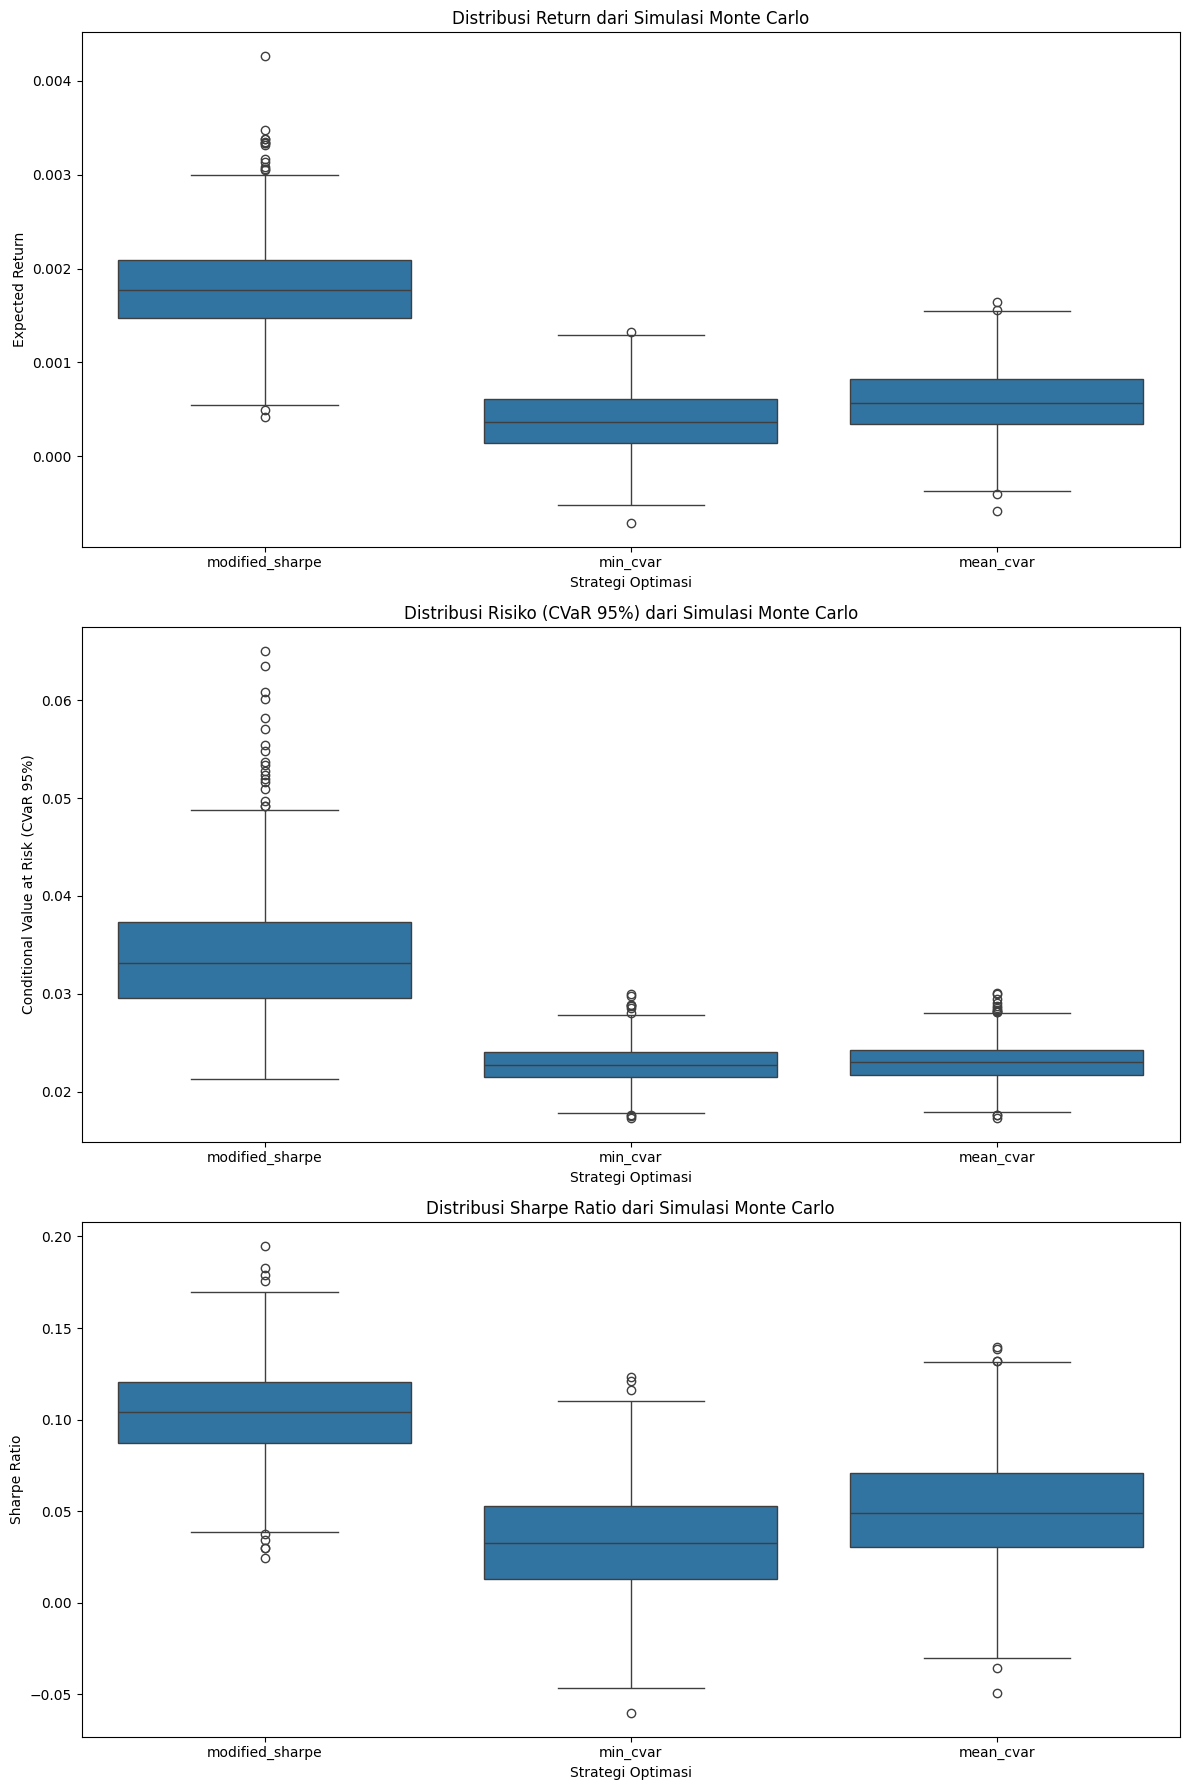

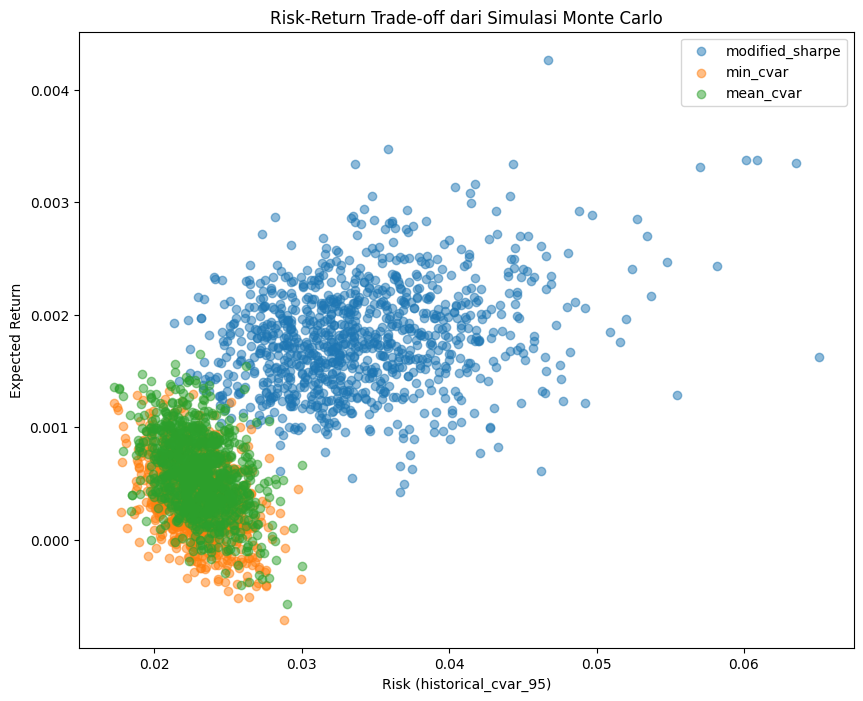


=== STATISTIK RINGKASAN SIMULASI MONTE CARLO ===
                 mean_return_mean  mean_return_std  mean_return_min  \
strategy                                                              
mean_cvar                0.000584         0.000341        -0.000576   
min_cvar                 0.000380         0.000327        -0.000712   
modified_sharpe          0.001795         0.000476         0.000423   

                 mean_return_max  mean_return_5pct  mean_return_95pct  \
strategy                                                                
mean_cvar               0.001648          0.000036           0.001141   
min_cvar                0.001319         -0.000162           0.000912   
modified_sharpe         0.004266          0.001079           0.002588   

                 volatility_mean  volatility_std  volatility_min  \
strategy                                                           
mean_cvar               0.011527        0.000856        0.009454   
min_cvar                

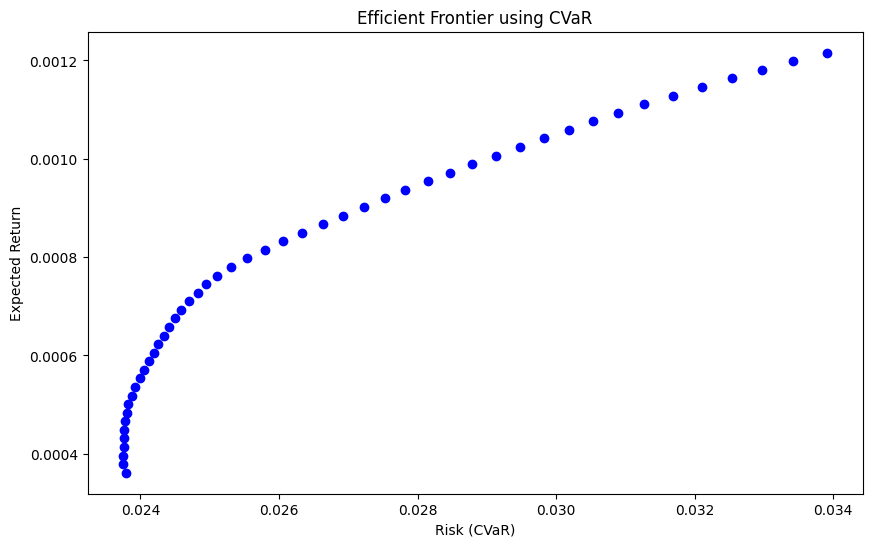

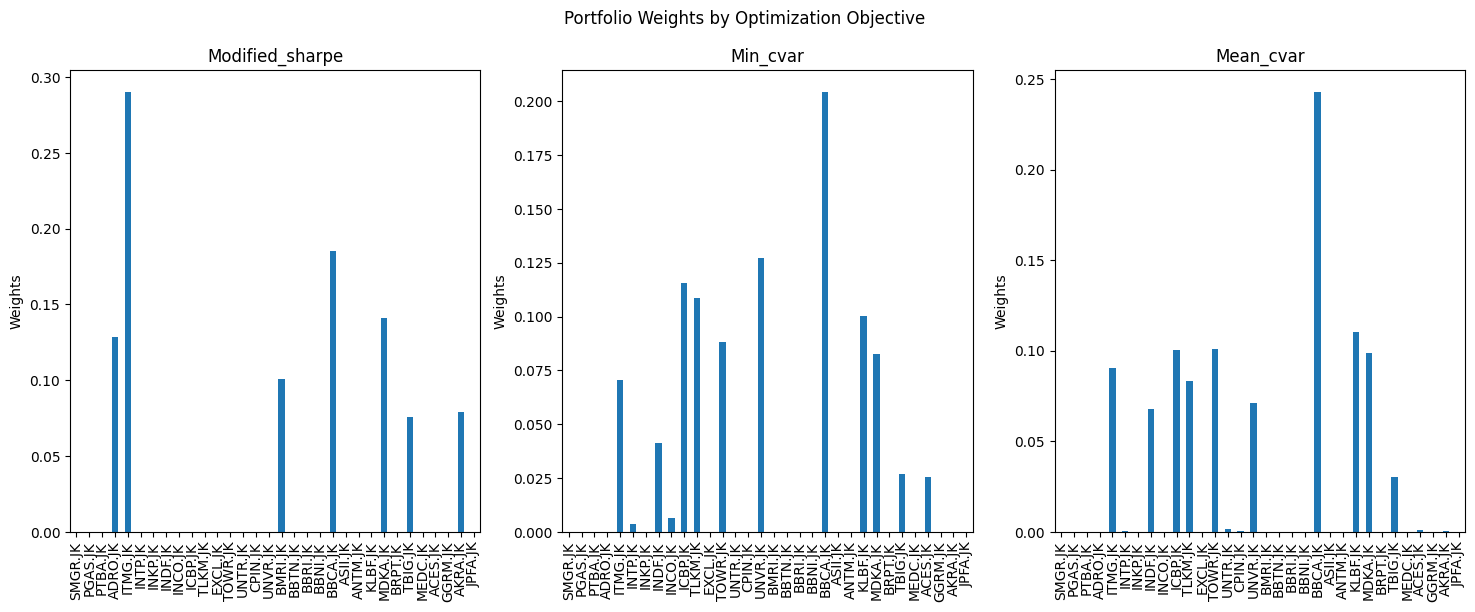


Individual Stock Metrics:
         Mean Return  Volatility  Sharpe Ratio  Skewness   Kurtosis
ADRO.JK     0.001806    0.028252      0.063922  0.371248   3.627931
ITMG.JK     0.001632    0.026530      0.061519  0.846646   4.003574
BMRI.JK     0.000983    0.021386      0.045987  0.193904   5.834545
PTBA.JK     0.001127    0.026310      0.042841  0.880909  10.241360
BBCA.JK     0.000663    0.015976      0.041472  1.063045  13.646677
AKRA.JK     0.001031    0.026319      0.039180  0.761477   3.838967
UNTR.JK     0.000921    0.024674      0.037309  0.983696   6.315229
MEDC.JK     0.001298    0.035320      0.036758  0.765250   3.686770
MDKA.JK     0.001038    0.030823      0.033682  0.939475   4.509056
TBIG.JK     0.000804    0.026177      0.030705  1.360718   9.983678
BBRI.JK     0.000638    0.021022      0.030348  0.912535   9.248427
BBNI.JK     0.000634    0.021758      0.029161  0.366602   5.160574
TOWR.JK     0.000517    0.021440      0.024098  0.847327   7.135161
ANTM.JK     0.000744 

In [79]:
lq45_tickers = pd.read_csv('./lq45/consistent_lq45_stocks.csv')['ticker']

# Periode analisis
start_date = '2019-09-01'
end_date = '2024-09-01'

results = run_portfolio_analysis(lq45_tickers, start_date, end_date)
print("\nIndividual Stock Metrics:")
print(results['stock_metrics'])

print("\nPortfolio Results:")
for objective, data in results['portfolio_results'].items():
    print(f"\nObjective: {objective}")
    print("Weights:")
    print(data['weights'])
    print("Metrics:")
    print(data['metrics'])
    # print("\nMonte Carlo Simulation Results (sample):")
    # print(data['monte_carlo_results'].head())

In [47]:
# return {
#         'returns_data': returns_data,
#         'stock_metrics': stock_metrics,
#         'portfolio_results': portfolio_results,
#         'frontier_data': frontier_data,
#         'benchmark_performance': benchmark_performance,
#         'monte_carlo_results': monte_carlo_results,
#         'plot': plt
#     }

print(results['frontier_data'].to_string())

      return      risk                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  weights
0   0.000362  0.023795                                                                 [2.965639154026913e-18, 1.2290507370201049e-18, 8.601193832774435e-18, 2.2542025632282626e-18, 0.07641866963233948, 0.007904044845300318, 4.6596594126756004e-18,

In [32]:
plt.show(results['plot'])

In [48]:
print(results['benchmark_performance'])

{'Mean Return': np.float64(0.0004779275222065336), 'Volatility': np.float64(0.013478397544838153), 'Sharpe Ratio': np.float64(0.035458779177318926)}


In [49]:
print(results['monte_carlo_results'].to_string())

      simulation_id         strategy  mean_return  volatility  sharpe_ratio  historical_var_95  historical_cvar_95  modified_sharpe
0                 0  modified_sharpe     0.001285    0.018871             0           0.025566            0.036777         0.034952
1                 0         min_cvar    -0.000096    0.011325             0           0.015621            0.025044        -0.003844
2                 0        mean_cvar     0.000051    0.011440             0           0.015919            0.025057         0.002053
3                 1  modified_sharpe     0.001575    0.016763             0           0.018849            0.032607         0.048293
4                 1         min_cvar     0.000556    0.012800             0           0.014423            0.025534         0.021780
5                 1        mean_cvar     0.000750    0.012994             0           0.014464            0.025466         0.029433
6                 2  modified_sharpe     0.001433    0.015646             0 

In [50]:
results['monte_carlo_results']

simulation_id         strategy  mean_return  volatility  sharpe_ratio  \
0                 0  modified_sharpe     0.001285    0.018871             0   
1                 0         min_cvar    -0.000096    0.011325             0   
2                 0        mean_cvar     0.000051    0.011440             0   
3                 1  modified_sharpe     0.001575    0.016763             0   
4                 1         min_cvar     0.000556    0.012800             0   
5                 1        mean_cvar     0.000750    0.012994             0   
6                 2  modified_sharpe     0.001433    0.015646             0   
7                 2         min_cvar     0.000277    0.010544             0   
8                 2        mean_cvar     0.000465    0.010675             0   
9                 3  modified_sharpe     0.001508    0.014753             0   
10                3         min_cvar     0.000492    0.011115             0   
11                3        mean_cvar     0.000676    0.011324             0   
12                4  modified_sharpe     0.001552    0.016999             0   
13                4         min_cvar     0.000234    0.010889             0   
14                4        mean_cvar     0.000478    0.010813             0   
15                5  modified_sharpe     0.001691    0.016367             0   
16                5         min_cvar     0.000394    0.011968             0   
17                5        mean_cvar     0.000517    0.011958             0   
18                6  modified_sharpe     0.001438    0.017141             0   
19                6         min_cvar     0.000150    0.011684             0   
20                6        mean_cvar     0.000326    0.011655             0   
21                7  modified_sharpe     0.003207    0.022541             0   
22                7         min_cvar     0.000599    0.012461             0   
23                7        mean_cvar     0.000971    0.012439             0   
24                8  modified_sharpe     0.001713    0.017864             0   
25                8         min_cvar     0.000238    0.009490             0   
26                8        mean_cvar     0.000534    0.009862             0   
27                9  modified_sharpe     0.003015    0.020155             0   
28                9         min_cvar     0.000345    0.011996             0   
29                9        mean_cvar     0.000851    0.012672             0   
30               10  modified_sharpe     0.001511    0.021071             0   
31               10         min_cvar    -0.000125    0.010812             0   
32               10        mean_cvar     0.000051    0.010832             0   
33               11  modified_sharpe     0.002047    0.017598             0   
34               11         min_cvar     0.000508    0.010672             0   
35               11        mean_cvar     0.000675    0.010844             0   
36               12  modified_sharpe     0.001421    0.016203             0   
37               12         min_cvar     0.000265    0.011558             0   
38               12        mean_cvar     0.000423    0.011596             0   
39               13  modified_sharpe     0.001652    0.014690             0   
40               13         min_cvar     0.000656    0.012002             0   
41               13        mean_cvar     0.000827    0.011891             0   
42               14  modified_sharpe     0.001672    0.014054             0   
43               14         min_cvar     0.000226    0.009564             0   
44               14        mean_cvar     0.000460    0.009693             0   
45               15  modified_sharpe     0.001776    0.018037             0   
46               15         min_cvar     0.000479    0.012499             0   
47               15        mean_cvar     0.000670    0.012719             0   
48               16  modified_sharpe     0.001599    0.015650             0   
49               16         min_cvar     0.000382    0.0

In [51]:
results['portfolio_results']

{'modified_sharpe': {'weights': SMGR.JK    0.000000e+00
  PGAS.JK    0.000000e+00
  PTBA.JK    7.946095e-17
  ADRO.JK    1.282457e-01
  ITMG.JK    2.903084e-01
  INTP.JK    1.256739e-17
  INKP.JK    0.000000e+00
  INDF.JK    0.000000e+00
  INCO.JK    1.243647e-17
  ICBP.JK    5.947262e-18
  TLKM.JK    2.274665e-18
  EXCL.JK    4.955196e-18
  TOWR.JK    0.000000e+00
  UNTR.JK    2.217730e-17
  CPIN.JK    0.000000e+00
  UNVR.JK    0.000000e+00
  BMRI.JK    1.005613e-01
  BBTN.JK    1.287615e-17
  BBRI.JK    0.000000e+00
  BBNI.JK    0.000000e+00
  BBCA.JK    1.850048e-01
  ASII.JK    1.271507e-17
  ANTM.JK    0.000000e+00
  KLBF.JK    6.130209e-18
  MDKA.JK    1.412693e-01
  BRPT.JK    2.348174e-18
  TBIG.JK    7.554118e-02
  MEDC.JK    0.000000e+00
  ACES.JK    9.722172e-18
  GGRM.JK    9.075184e-18
  AKRA.JK    7.906936e-02
  JPFA.JK    2.007463e-17
  dtype: float64,
  'metrics': {'mean_return': np.float64(0.0012157977455659148),
   'volatility': np.float64(0.016030499148010878),
   'h

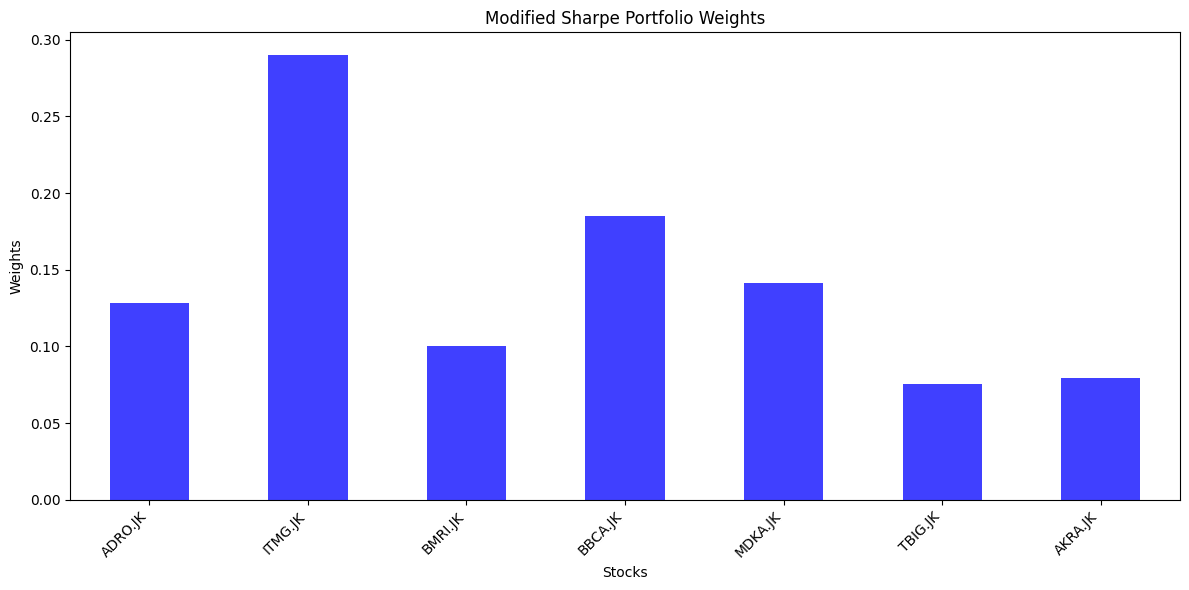

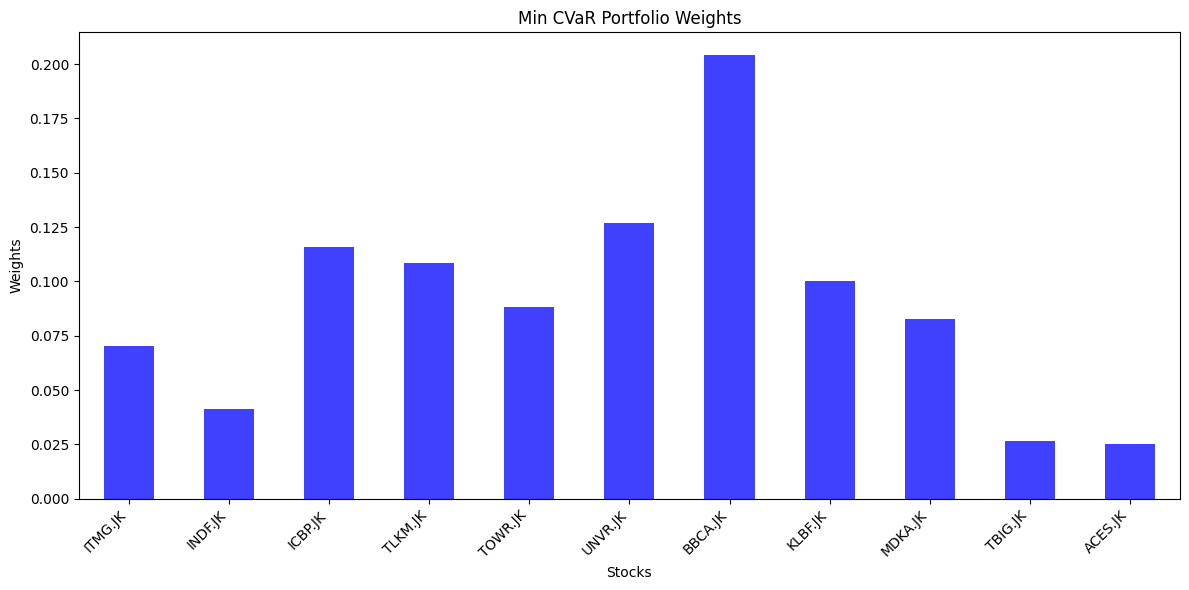

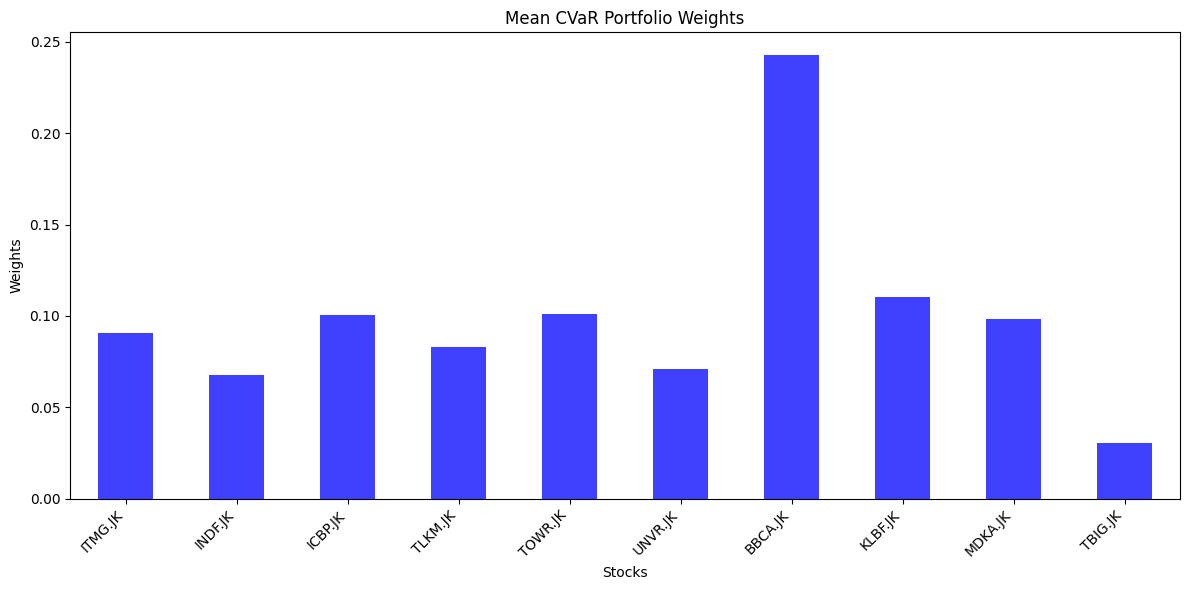

In [52]:
import matplotlib.pyplot as plt

# Portfolio weights dictionary from your results
portfolios = {
    "Modified Sharpe": results['portfolio_results']['modified_sharpe']['weights'],
    "Min CVaR": results['portfolio_results']['min_cvar']['weights'],
    "Mean CVaR": results['portfolio_results']['mean_cvar']['weights']
}

# Create separate bar plots for each portfolio
for portfolio_name, weights in portfolios.items():
    # Filter weights greater than 0
    positive_weights = weights[weights > 0.01]
    
    plt.figure(figsize=(12, 6))
    positive_weights.plot(kind='bar', color='blue', alpha=0.75)
    plt.title(f"{portfolio_name} Portfolio Weights")
    plt.xlabel("Stocks")
    plt.ylabel("Weights")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [53]:
print("\nEfficient Frontier Data:")
print(results['frontier_data'])



Efficient Frontier Data:
      return      risk  \
0   0.000362  0.023795   
1   0.000379  0.023744   
2   0.000396  0.023752   
3   0.000414  0.023756   
4   0.000431  0.023758   
5   0.000449  0.023768   
6   0.000466  0.023777   
7   0.000484  0.023799   
8   0.000501  0.023824   
9   0.000518  0.023873   
10  0.000536  0.023924   
11  0.000553  0.023987   
12  0.000571  0.024055   
13  0.000588  0.024117   
14  0.000606  0.024198   
15  0.000623  0.024257   
16  0.000641  0.024338   
17  0.000658  0.024405   
18  0.000675  0.024499   
19  0.000693  0.024583   
20  0.000710  0.024698   
21  0.000728  0.024824   
22  0.000745  0.024946   
23  0.000763  0.025100   
24  0.000780  0.025305   
25  0.000797  0.025542   
26  0.000815  0.025802   
27  0.000832  0.026060   
28  0.000850  0.026334   
29  0.000867  0.026630   
30  0.000885  0.026928   
31  0.000902  0.027231   
32  0.000919  0.027531   
33  0.000937  0.027825   
34  0.000954  0.028146   
35  0.000972  0.028475   
36  0.000989

In [54]:
print("\nEfficient Frontier Data:")
print(results['frontier_data'][['risk', 'return']])


Efficient Frontier Data:
        risk    return
0   0.023795  0.000362
1   0.023744  0.000379
2   0.023752  0.000396
3   0.023756  0.000414
4   0.023758  0.000431
5   0.023768  0.000449
6   0.023777  0.000466
7   0.023799  0.000484
8   0.023824  0.000501
9   0.023873  0.000518
10  0.023924  0.000536
11  0.023987  0.000553
12  0.024055  0.000571
13  0.024117  0.000588
14  0.024198  0.000606
15  0.024257  0.000623
16  0.024338  0.000641
17  0.024405  0.000658
18  0.024499  0.000675
19  0.024583  0.000693
20  0.024698  0.000710
21  0.024824  0.000728
22  0.024946  0.000745
23  0.025100  0.000763
24  0.025305  0.000780
25  0.025542  0.000797
26  0.025802  0.000815
27  0.026060  0.000832
28  0.026334  0.000850
29  0.026630  0.000867
30  0.026928  0.000885
31  0.027231  0.000902
32  0.027531  0.000919
33  0.027825  0.000937
34  0.028146  0.000954
35  0.028475  0.000972
36  0.028788  0.000989
37  0.029126  0.001007
38  0.029478  0.001024
39  0.029825  0.001041
40  0.030181  0.001059
41  0.03

In [37]:
print("\nBenchmark Performance:")
print(results['benchmark_performance'])



Benchmark Performance:
{'Mean Return': np.float64(0.0004779275222065336), 'Volatility': np.float64(0.013478397544838153), 'Sharpe Ratio': np.float64(0.035458779177318926)}


In [55]:
print("\nMonte Carlo Simulation Results (sample):")
print(results['monte_carlo_results'].head())



Monte Carlo Simulation Results (sample):
   simulation_id         strategy  mean_return  volatility  sharpe_ratio  \
0              0  modified_sharpe     0.001285    0.018871             0   
1              0         min_cvar    -0.000096    0.011325             0   
2              0        mean_cvar     0.000051    0.011440             0   
3              1  modified_sharpe     0.001575    0.016763             0   
4              1         min_cvar     0.000556    0.012800             0   

   historical_var_95  historical_cvar_95  modified_sharpe  
0           0.025566            0.036777         0.034952  
1           0.015621            0.025044        -0.003844  
2           0.015919            0.025057         0.002053  
3           0.018849            0.032607         0.048293  
4           0.014423            0.025534         0.021780  


In [59]:
print("\nMonte Carlo Simulation Results (sample):")
# print(results['monte_carlo_results'])

import pandas as pd

# Show all rows and columns without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Now print the DataFrame
print(pd.DataFrame(results['monte_carlo_results']))




Monte Carlo Simulation Results (sample):
      simulation_id         strategy  mean_return  volatility  sharpe_ratio  \
0                 0  modified_sharpe     0.001285    0.018871             0   
1                 0         min_cvar    -0.000096    0.011325             0   
2                 0        mean_cvar     0.000051    0.011440             0   
3                 1  modified_sharpe     0.001575    0.016763             0   
4                 1         min_cvar     0.000556    0.012800             0   
5                 1        mean_cvar     0.000750    0.012994             0   
6                 2  modified_sharpe     0.001433    0.015646             0   
7                 2         min_cvar     0.000277    0.010544             0   
8                 2        mean_cvar     0.000465    0.010675             0   
9                 3  modified_sharpe     0.001508    0.014753             0   
10                3         min_cvar     0.000492    0.011115             0   
11        

In [72]:
import pandas as pd

# Assuming this is your result DataFrame
monte_carlo_df = results['monte_carlo_results']

# Extract nested dict into separate columns
sharpe_metrics_df = monte_carlo_df['modified_sharpe']

# Now you can visualize
print(sharpe_metrics_df.head())  # optional

0    0.034952
1   -0.003844
2    0.002053
3    0.048293
4    0.021780
Name: modified_sharpe, dtype: float64


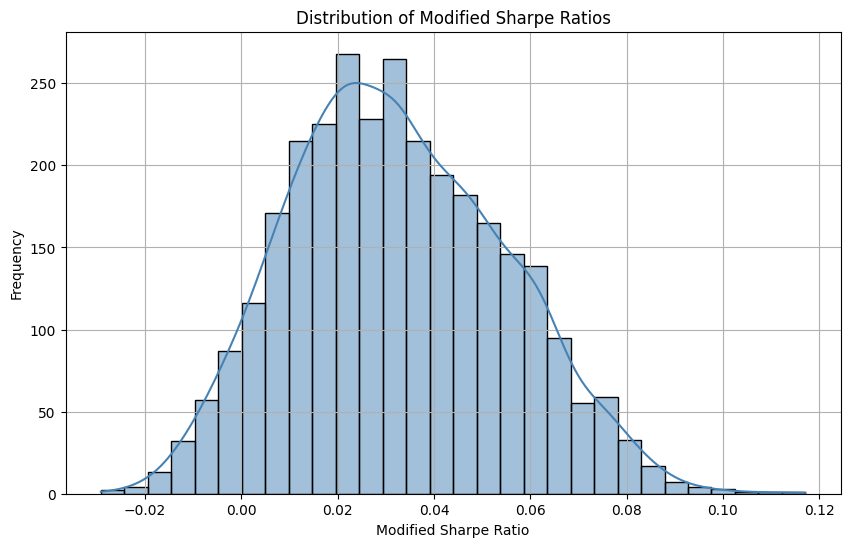

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(sharpe_metrics_df, bins=30, kde=True, color='steelblue')
plt.title("Distribution of Modified Sharpe Ratios")
plt.xlabel("Modified Sharpe Ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


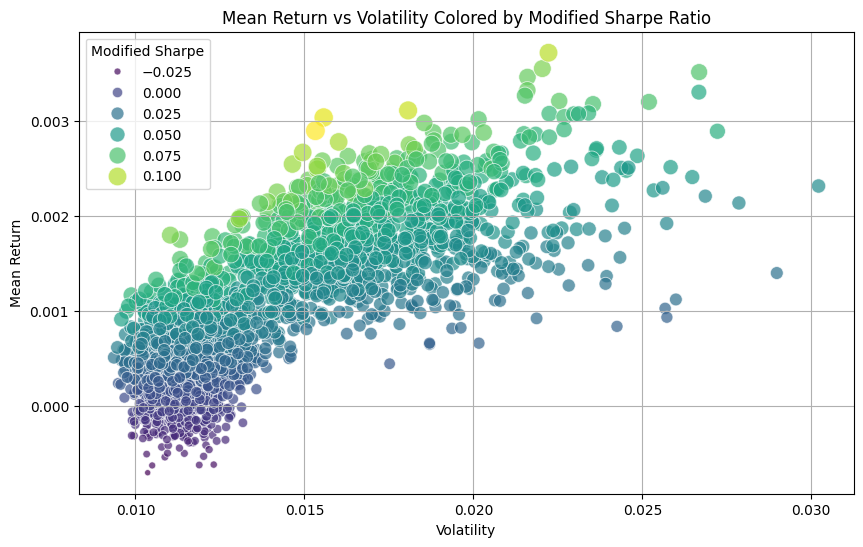

In [76]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=monte_carlo_df,
    x='volatility',
    y='mean_return',
    hue='modified_sharpe',
    palette='viridis',
    size='modified_sharpe',
    sizes=(20, 200),
    alpha=0.7
)
plt.title("Mean Return vs Volatility Colored by Modified Sharpe Ratio")
plt.xlabel("Volatility")
plt.ylabel("Mean Return")
plt.legend(title='Modified Sharpe')
plt.grid(True)
plt.show()


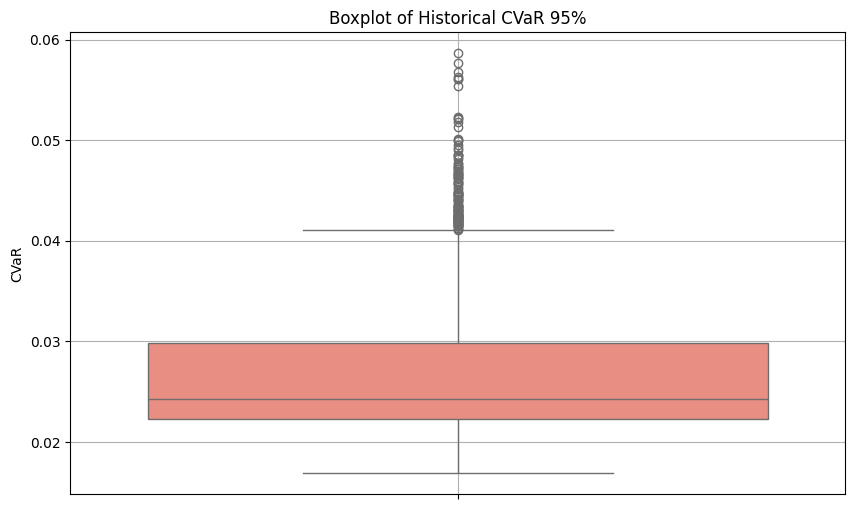

In [77]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=monte_carlo_df, y='historical_cvar_95', color='salmon')
plt.title("Boxplot of Historical CVaR 95%")
plt.ylabel("CVaR")
plt.grid(True)
plt.show()
